In [2]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[4], 'GPU')
            device = '/gpu:4'
    except RuntimeError as e:
        print(e)

print("device", device)


2024-09-24 19:16:12.136424: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 19:16:12.148999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 19:16:12.161759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 19:16:12.165630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 19:16:12.176497: I tensorflow/core/platform/cpu_feature_guar

device /gpu:4


In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

# import tensorflow as tf
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [4]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [5]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


My model

In [5]:
# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         x_input = layers.Input(shape=self.input_shape)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
        
#         x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         # x = layers.Dropout(0.1)(x)
        
#         x = layers.Flatten()(x)
        
        
        
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


Josh's model

In [5]:
# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-2, weights_path=None):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         x_input = layers.Input(shape=self.input_shape)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Flatten()(x)
               
#         x = layers.Dense(256, activation='relu')(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.Dense(128, activation='relu')(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.Dense(64, activation='relu')(x)
        
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


In [6]:
class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        x_input = layers.Input(shape=self.input_shape)
        
        x_1 = layers.Conv2D(64, kernel_size=6,strides =3, padding='same', activation='relu')(x_input)
        x_2 = layers.Conv2D(128, kernel_size=8,strides =3, padding='same', activation='relu')(x_input)
        x_3 = layers.Conv2D(256, kernel_size=19,strides =3, padding='same', activation='relu')(x_input)
        
        x = layers.concatenate([x_1, x_2, x_3])
        x = layers.Flatten()(x)
               
        x = layers.Dense(128, activation='relu')(x)
        # x = layers.Dropout(0.1)(x)
        x = layers.Dense(64, activation='relu')(x)
        # x = layers.Dropout(0.1)(x)
        x = layers.Dense(64, activation='relu')(x)
        
        
        
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [7]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/12KFixed_Mixed_13_SparsespotsRandomIndex.h5'             

data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


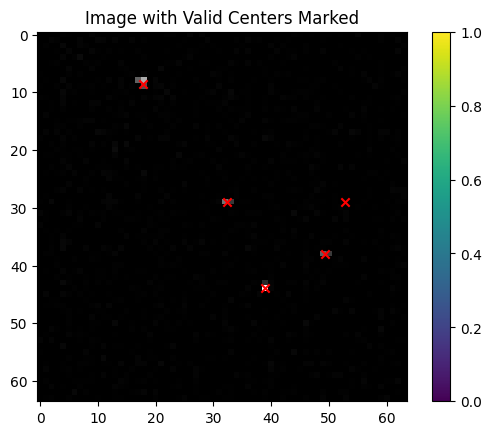

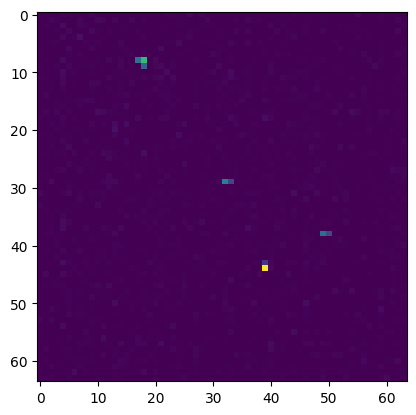

In [8]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [9]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


2024-09-24 19:18:20.032251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 4, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0


In [10]:

batch_size = 800
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (24000, 64, 64), Train Midpoints: (24000, 1, 5, 2)
Validation Images: (6000, 64, 64), Validation Midpoints: (6000, 1, 5, 2)


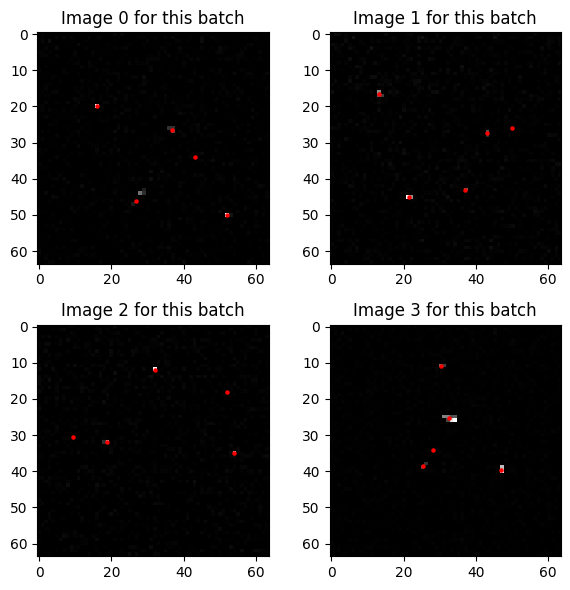

In [11]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [12]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='min', min_lr=7e-8
)


In [11]:
# import tensorflow as tf
##### used this initially 
# class DynamicHuberLoss(tf.keras.losses.Loss):
#     def __init__(self, initial_delta, final_delta, total_epochs, **kwargs):
#         super().__init__(**kwargs)
#         self.initial_delta = initial_delta
#         self.final_delta = final_delta
#         self.total_epochs = total_epochs
#         self.current_epoch = 0

#     def call(self, y_true, y_pred):
#         # Compute current delta
#         delta = self.initial_delta - ((self.initial_delta - self.final_delta) * (self.current_epoch / self.total_epochs))
#         # Compute Huber loss with current delta
#         return tf.keras.losses.huber(y_true, y_pred, delta=delta)

#     def update_epoch(self, epoch):
#         self.current_epoch = epoch

class DynamicHuberLoss(tf.keras.losses.Loss):
    def __init__(self, initial_delta=1.0, final_delta=0.5, total_epochs=450, **kwargs):
        super().__init__(**kwargs)
        self.initial_delta = initial_delta
        self.final_delta = final_delta
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def call(self, y_true, y_pred):
        # Dynamically adjust delta based on the current epoch
        delta = self.initial_delta - ((self.initial_delta - self.final_delta) * (self.current_epoch / self.total_epochs))
        error = y_true - y_pred
        abs_error = tf.abs(error)
        quadratic = tf.minimum(abs_error, delta)
        linear = abs_error - quadratic
        loss = 0.5 * quadratic**2 + delta * linear
        return tf.reduce_mean(loss)

    def update_epoch(self, epoch):
        self.current_epoch = epoch

In [12]:
# Instantiate the dynamic Huber loss
dynamic_huber_loss = DynamicHuberLoss(initial_delta=1.0, final_delta=0.5, total_epochs=450)



# Create a custom callback to update the epoch
class UpdateEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, loss_fn):
        super().__init__()
        self.loss_fn = loss_fn
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.loss_fn.update_epoch(epoch)

# Instantiate the callback
update_epoch_callback = UpdateEpochCallback(dynamic_huber_loss)



In [14]:
dynamic_exponent_callback = DynamicExponentCallback(1, 1, 50)
# Initialize the ModelBuilder within the strategy scope

# Instantiate the model builder
model_builder = ModelBuilder()

# Build the model
model_builder.build_model()

# Display the model architecture
model_builder.model.summary()

# Compile the model
model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(1))
    # If using a custom loss function, replace the above line with:
    # model_builder.compile_model(loss_function=custom_loss(exponent=2))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │      2,368 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │      8,320 │ input_layer_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 22, 22,    │     92,672 │ input_layer_2[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 22, 22,    │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 448)              │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 216832)    │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │ 27,754,624 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      4,160 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints (Dense) │ (None, 10)        │        650 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints_reshape │ (None, 1, 5, 2)   │          0 │ x_midpoints[0][0] │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,871,050 (106.32 MB)

 Trainable params: 27,871,050 (106.32 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:

# Train the model
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=400,
    callbacks_list=[lr_scheduler]
)


Epoch 1/400


2024-09-23 15:23:15.949285: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-23 15:23:15.961632: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-23 15:23:15.996505: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1727104996.051192 2784947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727104996.053565 2785003 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727104996.061265 2784958 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727104996.118799 2784947 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727104996.118780 2785003 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727104996.118828 2784958 gpu_timer.c

 2/30 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0793 

W0000 00:00:1727105008.225599 2784936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.226646 2784936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.227130 2785006 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.227852 2784936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.229274 2784936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.230013 2785006 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.231091 2784936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.232441 2784936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105008.237005 2785006 gp

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0566

2024-09-23 15:23:31.688078: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-23 15:23:31.688216: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-23 15:23:31.688342: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1727105012.655198 2784962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105012.655224 2784922 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105012.655407 2785000 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00

30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 570ms/step - loss: 0.0561 - val_loss: 0.2392 - learning_rate: 0.0100
Epoch 2/400


W0000 00:00:1727105024.649511 2784938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.658012 2784911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.658663 2784911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.659313 2784911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.660060 2784911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.660674 2784911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.661361 2784911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.662058 2784911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727105024.662691 2784911 gp

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0222

2024-09-23 15:23:48.766120: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.0222 - val_loss: 0.0358 - learning_rate: 0.0100
Epoch 3/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0187 - val_loss: 0.0297 - learning_rate: 0.0100
Epoch 4/400


2024-09-23 15:23:53.696177: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0173 - val_loss: 0.0298 - learning_rate: 0.0100
Epoch 5/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0167 - val_loss: 0.0296 - learning_rate: 0.0100
Epoch 6/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0161

2024-09-23 15:24:06.291728: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0161 - val_loss: 0.0292 - learning_rate: 0.0100
Epoch 7/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0156 - val_loss: 0.0287 - learning_rate: 0.0100
Epoch 8/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.0152 - val_loss: 0.0292 - learning_rate: 0.0100
Epoch 9/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0149 - val_loss: 0.0291 - learning_rate: 0.0100
Epoch 10/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0145 - val_loss: 0.0299 - learning_rate: 0.0100
Epoch 11/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0143 - val_loss: 0.0296 - learning_rate: 0.0100
Epoch 12/400


2024-09-23 15:24:28.777932: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0140 - val_loss: 0.0297 - learning_rate: 0.0100
Epoch 13/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0139 - val_loss: 0.0290 - learning_rate: 0.0100
Epoch 14/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0138 - val_loss: 0.0294 - learning_rate: 0.0100
Epoch 15/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0135 - val_loss: 0.0289 - learning_rate: 0.0100
Epoch 16/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0135 - val_loss: 0.0291 - learning_rate: 0.0100
Epoch 17/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0134
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0134 - val_loss: 0.0292 - learning_rate: 0.0100
Epoch 18/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0131 - val_loss: 0.0289 - learning_rate: 0.0080
Epoch 19/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0129 - val_loss: 0.0289 - learnin

2024-09-23 15:25:16.152677: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0126 - val_loss: 0.0166 - learning_rate: 0.0080
Epoch 23/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0125 - val_loss: 0.0153 - learning_rate: 0.0080
Epoch 24/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0125 - val_loss: 0.0289 - learning_rate: 0.0080
Epoch 25/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.0124 - val_loss: 0.0291 - learning_rate: 0.0080
Epoch 26/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0123 - val_loss: 0.0291 - learning_rate: 0.0080
Epoch 27/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0122 - val_loss: 0.0290 - learning_rate: 0.0080
Epoch 28/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0121 - val_loss: 0.0129 - learning_rate: 0.0080
Epoch 29/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0121 - val_loss: 0.0257 - learning_rate: 0.0080
Epoch 30/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0120 - val_loss: 0.0287 - learning_rate: 0.0080
Epoch

2024-09-23 15:26:48.580810: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0103
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0103 - val_loss: 0.0132 - learning_rate: 0.0080
Epoch 45/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0100 - val_loss: 0.0172 - learning_rate: 0.0064
Epoch 46/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0098 - val_loss: 0.0131 - learning_rate: 0.0064
Epoch 47/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0096 - val_loss: 0.0465 - learning_rate: 0.0064
Epoch 48/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0094 - val_loss: 0.0202 - learning_rate: 0.0064
Epoch 49/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0093 - val_loss: 0.0128 - learning_rate: 0.0064
Epoch 50/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0092 - val_loss: 0.0135 - learning_rate: 0.0064
Epoch 51/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0089 - val_loss: 0.0145 - learnin

2024-09-23 15:29:55.287839: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0035 - val_loss: 0.0143 - learning_rate: 0.0026
Epoch 87/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0034 - val_loss: 0.0135 - learning_rate: 0.0026
Epoch 88/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0034 - val_loss: 0.0135 - learning_rate: 0.0026
Epoch 89/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0033 - val_loss: 0.0146 - learning_rate: 0.0026
Epoch 90/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0033 - val_loss: 0.0135 - learning_rate: 0.0026
Epoch 91/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0032 - val_loss: 0.0144 - learning_rate: 0.0026
Epoch 92/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0032 - val_loss: 0.0145 - learning_rate: 0.0026
Epoch 93/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0031 - val_loss: 0.0137 - learning_rate: 0.0026
Epoch 94/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0030
Epoch 94: ReduceLROnPlateau reducing learning ra

2024-09-23 15:36:08.445125: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0016 - val_loss: 0.0140 - learning_rate: 4.3980e-04
Epoch 173/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0016 - val_loss: 0.0142 - learning_rate: 4.3980e-04
Epoch 174/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0016
Epoch 174: ReduceLROnPlateau reducing learning rate to 0.00035184368025511505.
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0016 - val_loss: 0.0140 - learning_rate: 4.3980e-04
Epoch 175/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0016 - val_loss: 0.0142 - learning_rate: 3.5184e-04
Epoch 176/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0016 - val_loss: 0.0141 - learning_rate: 3.5184e-04
Epoch 177/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0015 - val_loss: 0.0139 - learning_rate: 3.5184e-04
Epoch 178/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0015 - val_loss: 0.0139 - learning_rate: 3.5184e-04
Epoch 179/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - los

2024-09-23 15:48:34.109381: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0013 - val_loss: 0.0140 - learning_rate: 9.9035e-06
Epoch 344/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0013
Epoch 344: ReduceLROnPlateau reducing learning rate to 7.922815711935982e-06.
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0013 - val_loss: 0.0141 - learning_rate: 9.9035e-06
Epoch 345/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0013 - val_loss: 0.0141 - learning_rate: 7.9228e-06
Epoch 346/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0013 - val_loss: 0.0140 - learning_rate: 7.9228e-06
Epoch 347/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0013 - val_loss: 0.0140 - learning_rate: 7.9228e-06
Epoch 348/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0013 - val_loss: 0.0139 - learning_rate: 7.9228e-06
Epoch 349/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0013 - val_loss: 0.0145 - learning_rate: 7.9228e-06
Epoch 350/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss

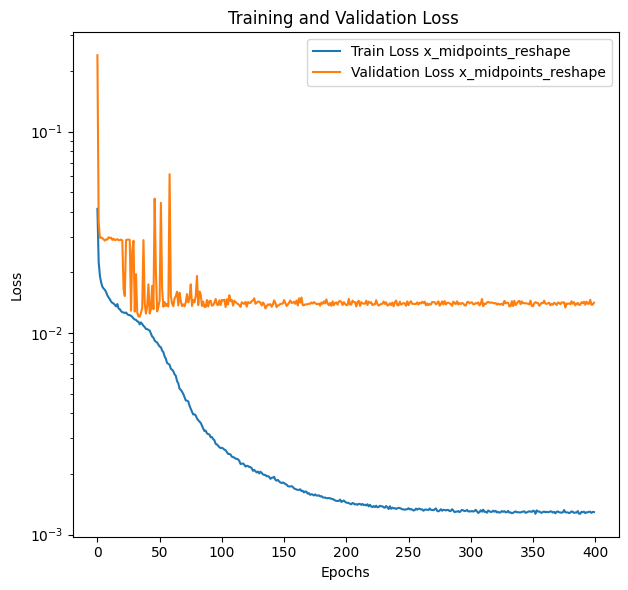

In [16]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
loaded_model = tf.keras.models.load_model(
 "/home/da886/Final Electron counting project/Experimental weights/Josh5fixedCustomloss.keras",
 )


In [15]:
# model_builder.model.save('/home/da886/Final Electron counting project/Experimental weights/JoshMSE5fixed.h5')

In [22]:
# # train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# # train_dataset = train_dataset.batch(800)
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
# inputs,targets = next(iter(val_dataset))
# outputs = loademodel.predict(inputs)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [17]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_midpoints(image, midpoints):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Predicted Midpoint Visualization")

#     # Plot midpoints directly
#     for i, (x, y) in enumerate(midpoints_np):
#         plt.scatter(x, y, color='red', s=5)

#     plt.show()

# def visualize_midpoints2(image, midpoints):
#     """
#     Visualizes ground truth midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
    
#     image_np = image
#     midpoints_np = midpoints
#     denormalized_image = image_np 

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Ground Truth Midpoint Visualization")

#     # Plot midpoints directly
#     for i, (x, y) in enumerate(midpoints_np):
#         plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Example usage with random data
# t = np.random.randint(0, 800)
# # t=100

# visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(outputs[t,0,:,:])*64)
# visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = loaded_model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


W0000 00:00:1727205825.025916 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.041518 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.041841 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.045200 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.045498 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.045780 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.046061 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.046399 1430162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727205825.046722 1430162 gp

Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
Processing batch 8, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
Processing batch 9, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
Processing batch 10, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing batch 11, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
Processing batch 12, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Processing batch 13, batch sha

2024-09-24 19:23:48.052990: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
predictions.shape

(800, 1, 5, 2)

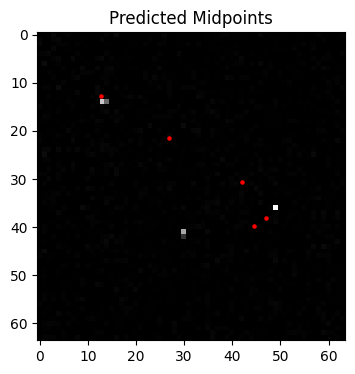

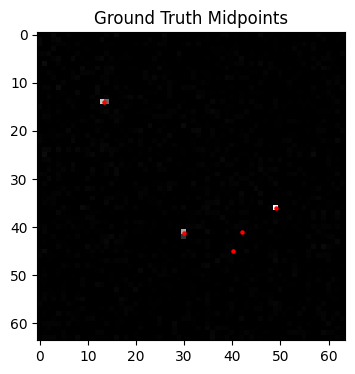

In [28]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


code to visualize Josh's edit

In [45]:
# model_builder.model.save('/home/da886/Electron Counting Extended Arch/Overfitted weights/increased_model_Padded_weights.keras')

In [268]:
val_loss = model_builder.model.evaluate(val_dataset)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.0136


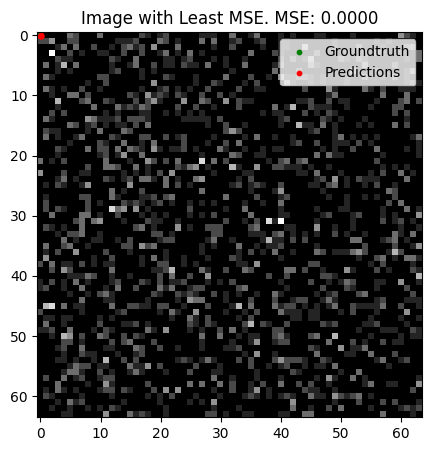

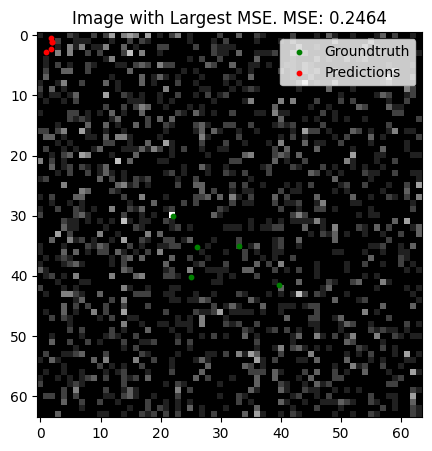

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) ** 2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')


